# Project 2: Mini deep-learning framework

You should be able to copy paste everything here to test.py

In [1]:
#!/usr/bin/env python3
""" File to solve the second miniproject which is the design of a framework """

import math
import matplotlib
import matplotlib.pyplot as plt

import torch
from torch import empty

__author__ = 'Eugène Lemaitre, Natalie Bolón Brun, Louis Munier'
__version__ = '0.1'

torch.set_grad_enabled(False)

In [2]:
from Linear import Linear
from Activation import Tanh, Relu, Sigmoid
from Loss import LossMSE, CrossEntropy
from Optimizers import Optimizers, Sgd, DecreaseSGD
from Sequential import Sequential

In [3]:
def compute_number_error(output_one_hot, target_one_hot):
    output = output_one_hot.argmax(dim=1)
    target = target_one_hot.argmax(dim=1)
    nb_of_error = (output != target).sum()
    return nb_of_error

## Data generation

In [4]:
def generate_disc_set(nb):
    X = empty(nb,2).uniform_(0,1)
    Y = empty(X.size())
    
    Y[:,0] = ((X - 0.5).norm(dim=1)  >  math.sqrt(1/(2*math.pi))).type(torch.LongTensor)
    Y[:,1] = ((X - 0.5).norm(dim=1)  <=  math.sqrt(1/(2*math.pi))).type(torch.LongTensor)
    
    return X, Y

def plot_disc(data_in, data_target, title):
    plt.scatter(data_in[(data_target[:,1]==1),0] ,data_in[(data_target[:,1]==1),1], color = "c", s=20)
    plt.scatter(data_in[(data_target[:,1]==0),0] ,data_in[(data_target[:,1]==0),1], color = "g", s=20)
    plt.title(title)
    plt.legend(["1", "0"] )
    plt.show()
    
def plot_result(data_in, data_target, data_class):
    one_id_as_one = torch.mul( (data_target[:,1]==1), (data_class ==1 ))
    one_id_as_zero = torch.mul( (data_target[:,1]==1), (data_class ==0 ))
    zero_id_as_one = torch.mul( (data_target[:,1]==0), (data_class ==1 ))
    zero_id_as_zero = torch.mul( (data_target[:,1]==0), (data_class ==0 ))
    
    plt.scatter(data_in[one_id_as_one,0] ,data_in[one_id_as_one,1], color = "c", s=20)
    plt.scatter(data_in[zero_id_as_zero,0] ,data_in[zero_id_as_zero,1], color = "g", s=20)
    plt.scatter(data_in[one_id_as_zero,0] ,data_in[one_id_as_zero,1], color = "r", s=20)
    plt.scatter(data_in[zero_id_as_one,0] ,data_in[zero_id_as_one,1], color = "y", s=20)
    
    plt.title("Result on train data")
    plt.legend(["1 id as 1", "0 id as 0", "1 id as 0", "0 id as 1"] )
    plt.show()
    
def plot_loss(epochs, loss):
    plt.plot(epochs, loss)
    plt.title("Loss")

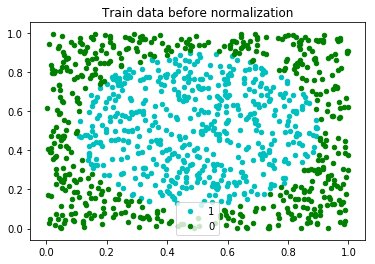

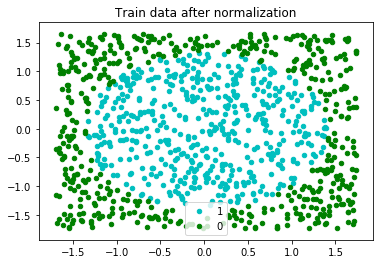

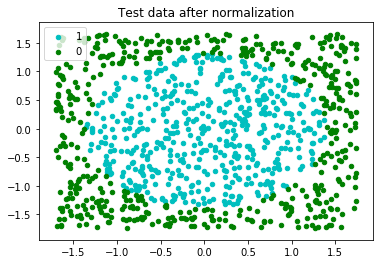

In [5]:
Sample_number = 1000
train_input, train_target = generate_disc_set(Sample_number)
test_input, test_target = generate_disc_set(Sample_number)


plot_disc(train_input, train_target, "Train data before normalization")

mu, std = train_input.mean(0), train_input.std(0)
train_input.sub_(mu).div_(std)
test_input.sub_(mu).div_(std)

plot_disc(train_input, train_target, "Train data after normalization")
plot_disc(test_input, test_target, "Test data after normalization")

## Model 1: No dropout, constant learning rate

In [6]:
hidden_nb = 25

linear_1 = Linear(2, hidden_nb)
relu_1 = Relu()
linear_2 = Linear(hidden_nb, hidden_nb)
relu_2 = Relu()
linear_3 = Linear(hidden_nb, hidden_nb)
relu_3 = Relu()
linear_4 = Linear(hidden_nb, 2)
loss = CrossEntropy()

model_1 = Sequential(linear_1, relu_1, linear_2, relu_2, linear_3, relu_3, linear_4, loss=CrossEntropy()) 
       
std = 0.1
eta = 3e-1
batch_size = 200
epochs_number = 1000

my_loss_1 = []

model_1.normalize_parameters(mean=0, std=std)
optimizer = Sgd()

for epochs in range(0, epochs_number):
    for b in range(0, Sample_number, batch_size):
        output = model_1.forward(train_input.narrow(0, b, batch_size))
        loss_value =  model_1.compute_loss(output, train_target.narrow(0, b, batch_size))
        model_1.backward()
        
        optimizer(model_1.sequence, eta=eta)
    
    if epochs%50 == 0:
        print(epochs, ": ", loss_value.item())
    my_loss_1.append(loss_value.item())

0 :  0.6895719170570374
50 :  0.11856506019830704
100 :  0.04707427695393562
150 :  0.02964172326028347
200 :  0.026586303487420082
250 :  0.0232092272490263
300 :  0.01842346228659153
350 :  0.02012023888528347
400 :  0.013171996921300888
450 :  0.013439331203699112
500 :  0.012833861634135246
550 :  0.011561889201402664
600 :  0.010516967624425888
650 :  0.010762939229607582
700 :  0.010280761867761612
750 :  0.011162719689309597
800 :  0.010369262658059597
850 :  0.010791625827550888
900 :  0.0068640136159956455
950 :  0.0048345946706831455



 
Loss:  0.006055664271116257
Number of errors:  2

 


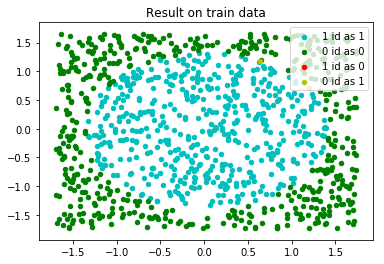

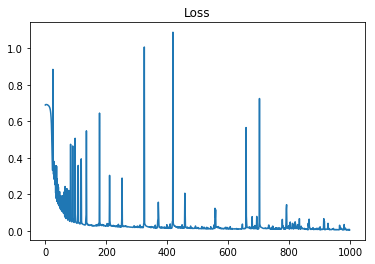

In [7]:
output = model_1.forward(train_input)
l = model_1.compute_loss(output, train_target)

print("\n ")
print("Loss: ", l.item())
print("Number of errors: ", compute_number_error(output, train_target).item())
print("\n ")


id_class_train = output.argmax(dim=1)
plot_result(train_input, train_target, id_class_train)
plot_loss(range(0, epochs_number), my_loss_1)


 
Loss:  0.026715820655226707
Number of errors:  11

 


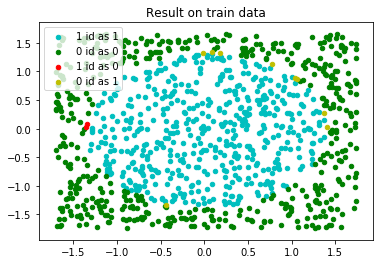

In [8]:
output = model_1.forward(test_input)
l = model_1.compute_loss(output, test_target)

print("\n ")
print("Loss: ", l.item())
print("Number of errors: ", compute_number_error(output, test_target).item())
print("\n ")


id_class_test = output.argmax(dim=1)
plot_result(test_input, test_target, id_class_test)


## Model 2: No dropout, deacreasing learning rate

In [9]:

linear_1 = Linear(2, hidden_nb)
relu_1 = Relu()
linear_2 = Linear(hidden_nb, hidden_nb)
relu_2 = Relu()
linear_3 = Linear(hidden_nb, hidden_nb)
relu_3 = Relu()
linear_4 = Linear(hidden_nb, 2)
loss = CrossEntropy()

model_2 = Sequential(linear_1, relu_1, linear_2, relu_2, linear_3, relu_3, linear_4, loss=CrossEntropy()) 
       
my_loss_2 = []

model_2.normalize_parameters(mean=0, std=std)
optimizer = DecreaseSGD()

for epochs in range(0, epochs_number):
    for b in range(0, Sample_number, batch_size):
        output = model_2.forward(train_input.narrow(0, b, batch_size))
        loss_value =  model_2.compute_loss(output, train_target.narrow(0, b, batch_size))
        model_2.backward()
        
        optimizer(epochs, model_2.sequence, eta=eta)
    
    if epochs%50 == 0:
        print(epochs, ": ", loss_value.item())
    my_loss_2.append(loss_value.item())

0 :  0.6973307132720947
50 :  0.6486635208129883
100 :  0.36542677879333496
150 :  0.18849578499794006
200 :  0.1352720558643341
250 :  0.11018463224172592
300 :  0.09549956768751144
350 :  0.08583923429250717
400 :  0.07925689220428467
450 :  0.07452529668807983
500 :  0.07094176858663559
550 :  0.06808806955814362
600 :  0.06571532785892487
650 :  0.06367462128400803
700 :  0.0618978850543499
750 :  0.06034698337316513
800 :  0.05901885777711868
850 :  0.05785949528217316
900 :  0.05679839849472046
950 :  0.055826108902692795



 
Loss:  0.05013696476817131
Number of errors:  7

 


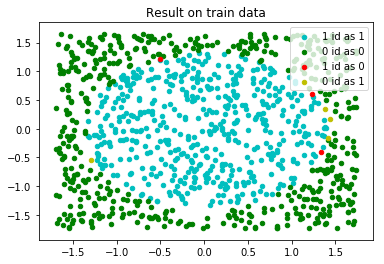

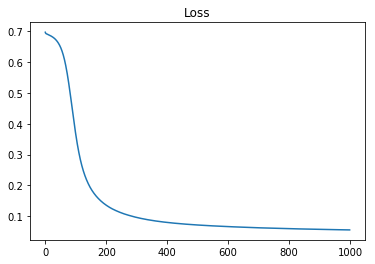

In [10]:
output = model_2.forward(train_input)
l = model_2.compute_loss(output, train_target)

print("\n ")
print("Loss: ", l.item())
print("Number of errors: ", compute_number_error(output, train_target).item())
print("\n ")


id_class_train = output.argmax(dim=1)
plot_result(train_input, train_target, id_class_train)
plot_loss(range(0, epochs_number), my_loss_2)


 
Loss:  0.06199878081679344
Number of errors:  19

 


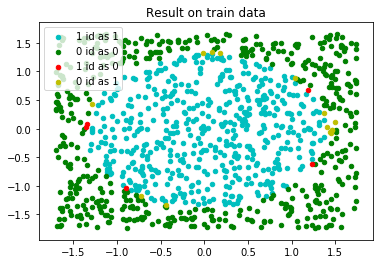

In [11]:
output = model_2.forward(test_input)
l = model_2.compute_loss(output, test_target)

print("\n ")
print("Loss: ", l.item())
print("Number of errors: ", compute_number_error(output, test_target).item())
print("\n ")


id_class_test = output.argmax(dim=1)
plot_result(test_input, test_target, id_class_test)


## Model 3: Dropout, constant learning rate

In [12]:
dropout = 0.25

linear_1 = Linear(2, hidden_nb)
relu_1 = Relu()
linear_2 = Linear(hidden_nb, hidden_nb, dropout=dropout)
relu_2 = Relu()
linear_3 = Linear(hidden_nb, hidden_nb, dropout=dropout)
relu_3 = Relu()
linear_4 = Linear(hidden_nb, 2)
loss = CrossEntropy()

model_3 = Sequential(linear_1, relu_1, linear_2, relu_2, linear_3, relu_3, linear_4, loss=CrossEntropy()) 
       

my_loss_3 = []

model_3.normalize_parameters(mean=0, std=std)
optimizer = Sgd()

for epochs in range(0, epochs_number):
    for b in range(0, Sample_number, batch_size):
        output = model_3.forward(train_input.narrow(0, b, batch_size))
        loss_value =  model_3.compute_loss(output, train_target.narrow(0, b, batch_size))
        model_3.backward()
        
        optimizer(model_3.sequence, eta=eta)
    
    if epochs%50 == 0:
        print(epochs, ": ", loss_value.item())
    my_loss_3.append(loss_value.item())

0 :  0.6910665035247803
50 :  0.427144318819046
100 :  0.1340954601764679
150 :  0.0545571893453598
200 :  0.07314056158065796
250 :  0.1816149801015854
300 :  0.03220275789499283
350 :  0.03128295764327049
400 :  0.0243536364287138
450 :  0.02118835411965847
500 :  0.012233275920152664
550 :  0.05386657640337944
600 :  0.029563598334789276
650 :  0.06030944734811783
700 :  0.0250091552734375
750 :  0.018155517056584358
800 :  0.0213775634765625
850 :  0.04540038853883743
900 :  nan
950 :  nan



 
Loss:  nan
Number of errors:  499

 


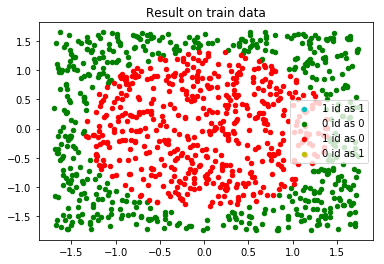

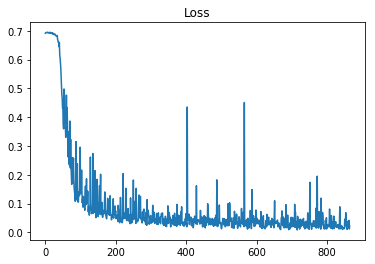

In [13]:
output = model_3.forward(train_input)
l = model_3.compute_loss(output, train_target)

print("\n ")
print("Loss: ", l.item())
print("Number of errors: ", compute_number_error(output, train_target).item())
print("\n ")


id_class_train = output.argmax(dim=1)
plot_result(train_input, train_target, id_class_train)
plot_loss(range(0, epochs_number), my_loss_3)


 
Loss:  nan
Number of errors:  507

 


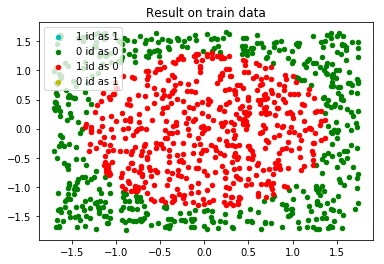

In [14]:
output = model_3.forward(test_input)
l = model_3.compute_loss(output, test_target)

print("\n ")
print("Loss: ", l.item())
print("Number of errors: ", compute_number_error(output, test_target).item())
print("\n ")


id_class_test = output.argmax(dim=1)
plot_result(test_input, test_target, id_class_test)


## Model 4: Same as 1 with tanh

In [15]:

linear_1 = Linear(2, hidden_nb)
relu_1 = Tanh()
linear_2 = Linear(hidden_nb, hidden_nb)
relu_2 = Tanh()
linear_3 = Linear(hidden_nb, hidden_nb)
relu_3 = Tanh()
linear_4 = Linear(hidden_nb, 2)
loss = CrossEntropy()

model_4 = Sequential(linear_1, relu_1, linear_2, relu_2, linear_3, relu_3, linear_4, loss=CrossEntropy()) 
       

my_loss_4 = []

model_4.normalize_parameters(mean=0, std=std)
optimizer = Sgd()

for epochs in range(0, epochs_number):
    for b in range(0, Sample_number, batch_size):
        output = model_4.forward(train_input.narrow(0, b, batch_size))
        loss_value =  model_4.compute_loss(output, train_target.narrow(0, b, batch_size))
        model_4.backward()
        
        optimizer(model_4.sequence, eta=eta)
    
    if epochs%50 == 0:
        print(epochs, ": ", loss_value.item())
    my_loss_4.append(loss_value.item())

0 :  0.6925665736198425
50 :  0.6947968006134033
100 :  0.6887932419776917
150 :  0.3106839060783386
200 :  0.1274450719356537
250 :  0.06962768733501434
300 :  0.05409637466073036
350 :  0.04752960056066513
400 :  0.04325561597943306
450 :  0.03940337896347046
500 :  0.044705502688884735
550 :  0.03248962387442589
600 :  0.03347320482134819
650 :  0.033694762736558914
700 :  0.03356323018670082
750 :  0.03283752501010895
800 :  0.031874388456344604
850 :  0.030620116740465164
900 :  0.03412231430411339
950 :  0.045595090836286545



 
Loss:  0.024907227605581284
Number of errors:  12

 


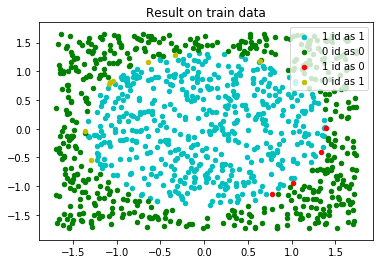

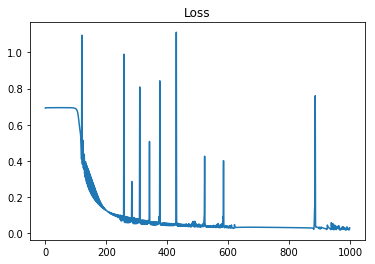

In [16]:
output = model_4.forward(train_input)
l = model_4.compute_loss(output, train_target)

print("\n ")
print("Loss: ", l.item())
print("Number of errors: ", compute_number_error(output, train_target).item())
print("\n ")


id_class_train = output.argmax(dim=1)
plot_result(train_input, train_target, id_class_train)
plot_loss(range(0, epochs_number), my_loss_4)


 
Loss:  0.02927246317267418
Number of errors:  11

 


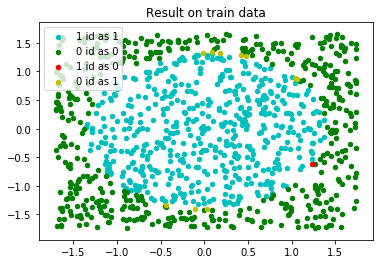

In [17]:
output = model_4.forward(test_input)
l = model_4.compute_loss(output, test_target)

print("\n ")
print("Loss: ", l.item())
print("Number of errors: ", compute_number_error(output, test_target).item())
print("\n ")


id_class_test = output.argmax(dim=1)
plot_result(test_input, test_target, id_class_test)


## Model 5: Same as 1 with Sigmoid

In [18]:
p_lambda = 0.1

linear_1 = Linear(2, hidden_nb)
relu_1 = Sigmoid(p_lambda)
linear_2 = Linear(hidden_nb, hidden_nb)
relu_2 = Sigmoid(p_lambda)
linear_3 = Linear(hidden_nb, hidden_nb)
relu_3 = Sigmoid(p_lambda)
linear_4 = Linear(hidden_nb, 2)
loss = CrossEntropy()

model_5 = Sequential(linear_1, relu_1, linear_2, relu_2, linear_3, relu_3, linear_4, loss=CrossEntropy()) 
       

my_loss_5 = []

model_5.normalize_parameters(mean=0, std=std)
optimizer = Sgd()

for epochs in range(0, epochs_number):
    for b in range(0, Sample_number, batch_size):
        output = model_5.forward(train_input.narrow(0, b, batch_size))
        loss_value =  model_5.compute_loss(output, train_target.narrow(0, b, batch_size))
        model_5.backward()
        
        optimizer(model_5.sequence, eta=eta)
    
    if epochs%50 == 0:
        print(epochs, ": ", loss_value.item())
    my_loss_5.append(loss_value.item())

0 :  0.6926969289779663
50 :  0.6939212083816528
100 :  0.6939207315444946
150 :  0.693920910358429
200 :  0.6939207911491394
250 :  0.6939210891723633
300 :  0.6939212679862976
350 :  0.693920910358429
400 :  0.6939212679862976
450 :  0.6939210295677185
500 :  0.6939207315444946
550 :  0.6939207315444946
600 :  0.6939206719398499
650 :  0.6939207315444946
700 :  0.6939207315444946
750 :  0.6939207315444946
800 :  0.6939207315444946
850 :  0.6939207315444946
900 :  0.6939207315444946
950 :  0.6939207315444946



 
Loss:  0.6931813359260559
Number of errors:  501

 


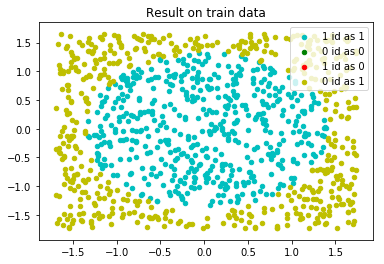

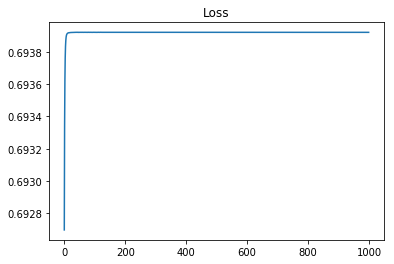

In [19]:
output = model_5.forward(train_input)
l = model_5.compute_loss(output, train_target)

print("\n ")
print("Loss: ", l.item())
print("Number of errors: ", compute_number_error(output, train_target).item())
print("\n ")


id_class_train = output.argmax(dim=1)
plot_result(train_input, train_target, id_class_train)
plot_loss(range(0, epochs_number), my_loss_5)


 
Loss:  0.6930771470069885
Number of errors:  493

 


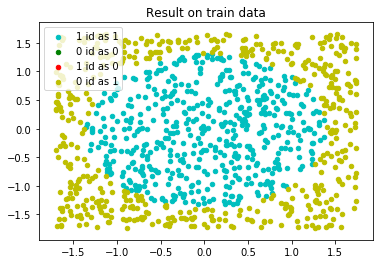

In [20]:
output = model_5.forward(test_input)
l = model_5.compute_loss(output, test_target)

print("\n ")
print("Loss: ", l.item())
print("Number of errors: ", compute_number_error(output, test_target).item())
print("\n ")


id_class_test = output.argmax(dim=1)
plot_result(test_input, test_target, id_class_test)


## Model 6: Same as 1 but with MSE

In [21]:

linear_1 = Linear(2, hidden_nb)
relu_1 = Relu()
linear_2 = Linear(hidden_nb, hidden_nb)
relu_2 = Relu()
linear_3 = Linear(hidden_nb, hidden_nb)
relu_3 = Relu()
linear_4 = Linear(hidden_nb, 2)
loss = LossMSE()

model_6 = Sequential(linear_1, relu_1, linear_2, relu_2, linear_3, relu_3, linear_4, loss=CrossEntropy()) 
       


my_loss_6 = []

model_6.normalize_parameters(mean=0, std=std)
optimizer = Sgd()

for epochs in range(0, epochs_number):
    for b in range(0, Sample_number, batch_size):
        output = model_6.forward(train_input.narrow(0, b, batch_size))
        loss_value =  model_6.compute_loss(output, train_target.narrow(0, b, batch_size))
        model_6.backward()
        
        optimizer(model_6.sequence, eta=eta)
    
    if epochs%50 == 0:
        print(epochs, ": ", loss_value.item())
    my_loss_6.append(loss_value.item())

0 :  0.6909483075141907
50 :  0.1657916158437729
100 :  0.04443420469760895
150 :  0.029703369364142418
200 :  0.026024170219898224
250 :  0.02619018405675888
300 :  0.023723144084215164
350 :  0.023311767727136612
400 :  0.022216185927391052
450 :  0.013261718675494194
500 :  0.020647581666707993
550 :  0.018322143703699112
600 :  0.015607910230755806
650 :  0.012402953580021858
700 :  0.009922484867274761
750 :  0.007845458574593067
800 :  0.008840331807732582
850 :  0.0065148924477398396
900 :  0.0071099852211773396
950 :  0.011295165866613388



 
Loss:  0.014545898884534836
Number of errors:  7

 


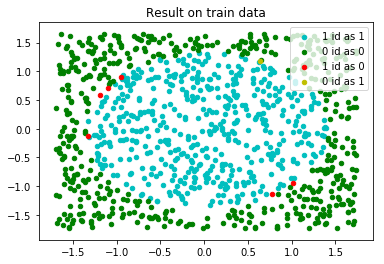

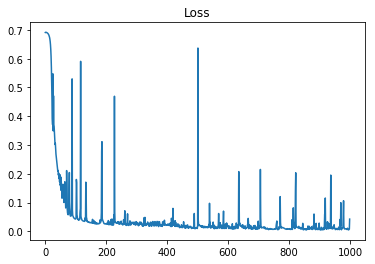

In [22]:
output = model_6.forward(train_input)
l = model_6.compute_loss(output, train_target)

print("\n ")
print("Loss: ", l.item())
print("Number of errors: ", compute_number_error(output, train_target).item())
print("\n ")


id_class_train = output.argmax(dim=1)
plot_result(train_input, train_target, id_class_train)
plot_loss(range(0, epochs_number), my_loss_6)


 
Loss:  0.02658691443502903
Number of errors:  11

 


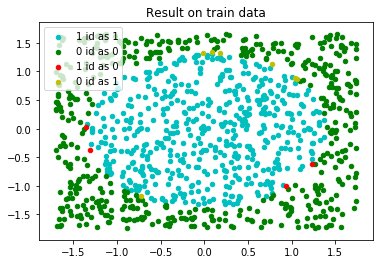

In [23]:
output = model_6.forward(test_input)
l = model_6.compute_loss(output, test_target)

print("\n ")
print("Loss: ", l.item())
print("Number of errors: ", compute_number_error(output, test_target).item())
print("\n ")


id_class_test = output.argmax(dim=1)
plot_result(test_input, test_target, id_class_test)


## All graphs

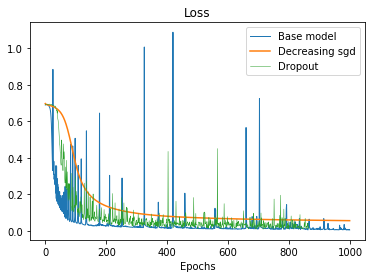

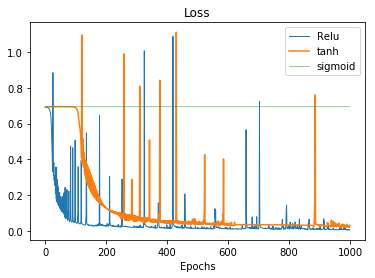

In [24]:

plt.plot(range(0, epochs_number), my_loss_1, linewidth=1)
plt.plot(range(0, epochs_number), my_loss_2)
plt.plot(range(0, epochs_number), my_loss_3,  linewidth=0.5)
plt.legend(["Base model", "Decreasing sgd", "Dropout"])
plt.title("Loss")
plt.xlabel("Epochs")
plt.show()

plt.plot(range(0, epochs_number), my_loss_1, linewidth=1)
plt.plot(range(0, epochs_number), my_loss_4)
plt.plot(range(0, epochs_number), my_loss_5,  linewidth=0.5)
plt.legend(["Relu", "tanh", "sigmoid"])
plt.title("Loss")
plt.xlabel("Epochs")
plt.show()